In [1]:
import os
import os.path as op
import pandas as pd
from nilearn import image, signal
from load_confounds import Confounds
from shinobi_fmri.annotations.annotations import trim_events_df, get_scrub_regressor
import numpy as np
import pdb
import argparse
import nilearn
import shinobi_behav
from nilearn.glm.first_level import make_first_level_design_matrix, FirstLevelModel
from nilearn.glm import threshold_stats_img
from nilearn import plotting
from nilearn.image import clean_img
from nilearn.reporting import get_clusters_table
from nilearn import input_data
from nilearn import plotting
import matplotlib.pyplot as plt
from nilearn.signal import clean
import nibabel as nib
import logging
import pickle
from nilearn.plotting import plot_img_on_surf, plot_stat_map

/home/hyruuk/python_envs/shinobi_env/lib/python3.7/site-packages/nilearn/datasets/__init__.py:96: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)
/home/hyruuk/python_envs/shinobi_env/lib/python3.7/site-packages/nilearn/glm/__init__.py:56: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  'It may change in any future release of Nilearn.', FutureWarning)


In [2]:
# Constants
t_r = 1.49
hrf_model = "spm"
contrasts = ["Hit", "Kill", "Jump"]


In [3]:
def create_output_folders(path_to_data, figures_path, contrasts):
    # Create output folders if needed
    os.makedirs(op.join(figures_path, "design_matrices"), exist_ok=True)
    for contrast in contrasts:
        os.makedirs(
            op.join(path_to_data, "processed", "z_maps", "run-level", contrast), exist_ok=True)
        os.makedirs(op.join(figures_path, "run-level", contrast), exist_ok=True)



In [10]:
# Make filenames

path_to_data = "/scratch/hyruuk/neuromod/shinobi2023"
sub = "sub-02"
ses = "ses-013"
run = "5"

fmri_fname = op.join(
    path_to_data,
    "shinobi.fmriprep",
    sub,
    ses,
    "func",
    f"{sub}_{ses}_task-shinobi_run-{run}_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz",
)
assert op.isfile(fmri_fname), f"fMRI file not found for {sub}_{ses}_{run}"

anat_fname = op.join(
    path_to_data,
    "cneuromod.processed",
    "smriprep",
    sub,
    "anat",
    f"{sub}_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz",
)
assert op.isfile(anat_fname), f"sMRI file not found for {sub}_{ses}_{run}"

events_fname = op.join(
    path_to_data, 
    "shinobi", 
    sub,
    ses,
    "func",
    f"{sub}_{ses}_task-shinobi_run-0{run}_annotated_events.tsv"
)
assert op.isfile(events_fname), f"Annotated events file not found for {sub}_{ses}_{run}" 

In [11]:
# Load events
run_events = pd.read_csv(events_fname, sep="\t", index_col=[0])

# Select events
annotation_events = run_events[run_events["trial_type"].isin(['B', 'C', 'DOWN', 'HealthGain', 'HealthLoss', 'Kill', 'LEFT',
       'RIGHT', 'UP'])] # add 'frame' here
annotation_events = annotation_events[["trial_type", "onset", "duration"]]
annotation_events

/home/hyruuk/python_envs/shinobi_env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,trial_type,onset,duration
47,RIGHT,168.8929,0.067
57,RIGHT,169.0259,2.700
165,B,170.8099,0.833
228,UP,171.8429,0.617
231,C,171.8759,0.650
...,...,...,...
33674,RIGHT,730.8632,0.100
33684,RIGHT,731.0132,2.217
33762,C,732.2802,0.166
33777,HealthGain,732.5132,0.100


In [12]:
# Load and clean 4d image
fmri_img = clean_img(
    fmri_fname,
    standardize=True,
    detrend=True,
    high_pass=None,
    t_r=t_r,
    ensure_finite=True,
    confounds=None,
)

# Load and resample (i.e. morph  ?) anat mask
aff_orig = nib.load(fmri_fname).affine[:, -1]
target_affine = np.column_stack([np.eye(4, 3) * 4, aff_orig])
anat_img = image.resample_img(anat_fname, target_affine=target_affine, target_shape=fmri_img.get_fdata().shape[:3])

/home/hyruuk/python_envs/shinobi_env/lib/python3.7/site-packages/nilearn/image/image.py:1109: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  ensure_finite=ensure_finite)
/home/hyruuk/python_envs/shinobi_env/lib/python3.7/site-packages/nilearn/image/resampling.py:273: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn("Resampling binary images with continuous or "


In [30]:
# Make design matrix

# Load confounds
confounds = Confounds(
    strategy=["high_pass", "motion", "global", "wm_csf"],
    motion="full",
    wm_csf="basic",
    global_signal="full",
).load(fmri_fname)

# Generate design matrix
bold_shape = fmri_img.shape
n_slices = bold_shape[-1]
frame_times = np.arange(n_slices) * t_r
design_matrix_raw = make_first_level_design_matrix(
    frame_times,
    events=annotation_events,
    drift_model=None,
    hrf_model=hrf_model,
    add_regs=confounds,
    add_reg_names=None,
)

# Clean regressors 
regressors_clean = clean(
    design_matrix_raw.to_numpy(),
    detrend=True,
    standardize=True,
    high_pass=None,
    t_r=t_r,
    ensure_finite=True,
    confounds=None,
)

# Recombine design_matrix (restoring constant after cleaning and adding scrub regressors)
design_matrix_clean = pd.DataFrame(
    regressors_clean, columns=design_matrix_raw.columns.to_list()
)
design_matrix_clean["constant"] = 1
design_matrix_clean = get_scrub_regressor(run_events, design_matrix_clean)


# Plot design matrix


[trial_type      gym-retro_game
onset                   0.0094
duration              162.0832
duration_bk2             163.1
level                      1.0
                     ...      
RIGHT                      NaN
C                          NaN
Y                          NaN
X                          NaN
Z                          NaN
Name: 0, Length: 117, dtype: object, trial_type      gym-retro_game
onset                 168.1429
duration               59.9498
duration_bk2         59.966667
level                      4.0
                     ...      
RIGHT                      NaN
C                          NaN
Y                          NaN
X                          NaN
Z                          NaN
Name: 2, Length: 117, dtype: object, trial_type      gym-retro_game
onset                 234.1268
duration              161.3841
duration_bk2             161.4
level                      5.0
                     ...      
RIGHT                      NaN
C                         

RangeIndex(start=0, stop=494, step=1)

<AxesSubplot:label='conditions', ylabel='scan number'>

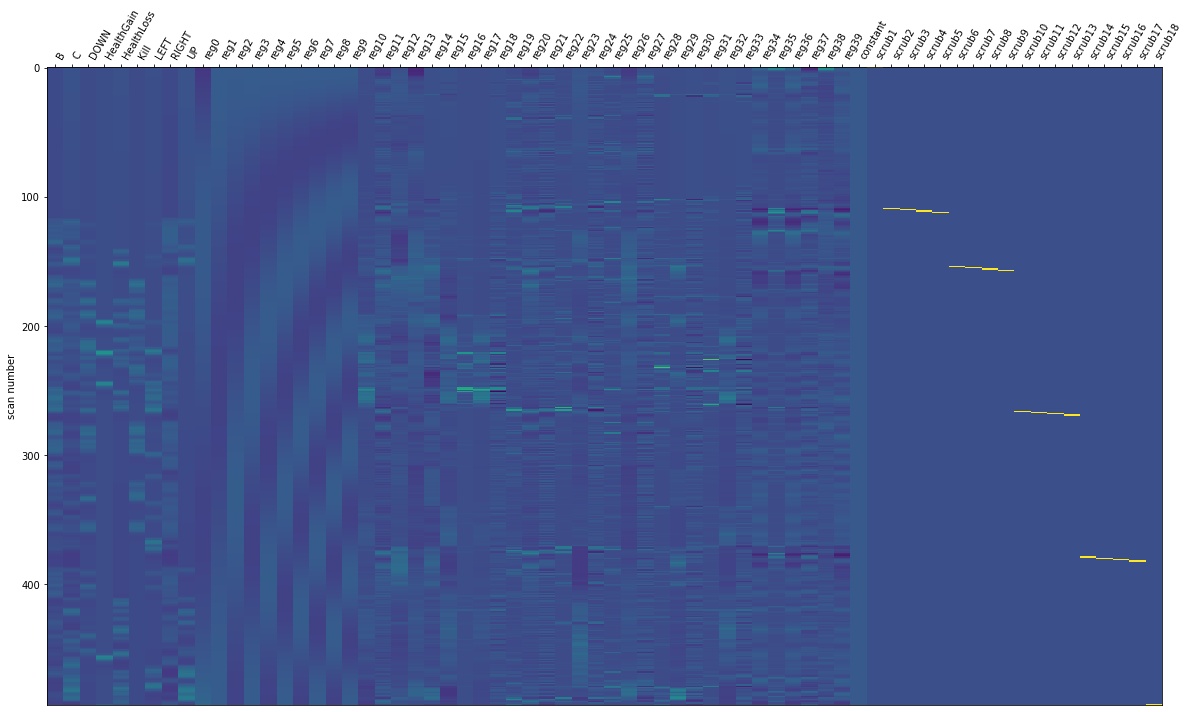

In [31]:
plotting.plot_design_matrix(
    design_matrix_clean
)

In [11]:
run_events[run_events["trial_type"] == "gym-retro_game"]

,trial_type,onset,duration,duration_bk2,level,stim_file,frame_idx,texture_player_2,texture_player_1,first_d5,...,MODE,START,UP,DOWN,LEFT,RIGHT,C,Y,X,Z
0,gym-retro_game,0.0160,167.0816,167.150000,1-0,sub-01/ses-004/gamelogs/sub-01_ses-004_task-sh...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10355,gym-retro_game,173.1477,144.9855,145.000000,4-1,sub-01/ses-004/gamelogs/sub-01_ses-004_task-sh...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19358,gym-retro_game,324.1835,156.1184,156.133333,5-0,sub-01/ses-004/gamelogs/sub-01_ses-004_task-sh...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29055,gym-retro_game,486.3357,159.6189,159.616667,1-0,sub-01/ses-004/gamelogs/sub-01_ses-004_task-sh...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
# Fit GLM
fmri_glm = FirstLevelModel(
    t_r=t_r,
    noise_model="ar1",
    standardize=False,
    hrf_model=hrf_model,
    drift_model=None,
    high_pass=None,
    n_jobs=16,
    smoothing_fwhm=5,
    mask_img=anat_img,
    minimize_memory=False,
)
fmri_glm = fmri_glm.fit(fmri_img, design_matrices=design_matrix_clean)

with open(glm_fname, "wb") as f:
    pickle.dump(fmri_glm, f)

/home/hyruuk/python_envs/shinobi_env/lib/python3.7/site-packages/nilearn/glm/first_level/first_level.py:63: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn('Mean values of 0 observed.'


In [40]:
glm_fname = op.join(path_to_data,
                    "processed25122022",
                    "glm",
                    "run-level",
                    f"{sub}_{ses}_run-0{run}_fitted_glm.pkl")

os.makedirs(op.join(path_to_data,
                    "processed25122022",
                    "glm",
                    "run-level"), exist_ok=True)

with open(glm_fname, "wb") as f:
    pickle.dump(fmri_glm, f)

In [41]:
glm_fname

'/scratch/hyruuk/neuromod/shinobi2023/processed25122022/glm/run-level/sub-02_ses-013_run-05_fitted_glm.pkl'

In [42]:
path_to_data

'/scratch/hyruuk/neuromod/shinobi2023'

In [53]:
import glob
filelist = glob.glob(op.join(path_to_data, "shinobi.fmriprep", "*", "*", "*", "*.nii.gz"))

In [61]:
for file in filelist:
    sub = file.split("/")[-1].split("_")[0]
    ses = file.split("/")[-1].split("_")[1]
    run = file.split("/")[-1].split("_")[3][-1]

4
4
3
5
2
2
3
4
1
4
2
3
3
3
5
1
1
4
5
1
5
3
2
3
4
5
5
2
2
2
1
5
4
2
1
1
5
3
3
2
2
4
1
1
3
5
4
1
5
4
4
4
1
5
2
2
5
2
3
4
4
3
5
4
4
3
1
3
2
2
3
3
5
4
3
2
1
1
5
4
1
5
5
3
4
4
1
1
2
3
5
1
3
1
2
2
5
1
5
2
1
5
2
3
2
5
3
5
1
1
1
2
4
5
4
5
3
2
2
1
3
1
5
4
2
3
2
3
5
1
2
5
2
4
1
5
4
5
4
4
3
4
2
1
3
4
1
3
4
3
2
5
2
3
3
3
4
2
3
1
4
1
4
1
1
2
5
2
1
3
2
3
2
2
1
3
2
2
3
4
4
1
5
4
4
5
4
1
3
3
5
4
5
5
4
5
1
1
5
5
3
2
5
2
4
5
5
1
3
1
5
1
4
2
3
2
3
2
3
1
2
5
4
1
5
2
3
2
4
1
3
5
1
5
5
4
4
3
4
1
2
4
2
4
1
1
4
5
3
3
2
5
2
1
4
3
5
4
3
5
5
3
1
1
2
1
1
2
5
2
1
5
4
3
1
1
5
3
4
1
3
4
2
2
4
1
3
2
5
5
3
2
4
3
5
3
4
4
4
2
3
2
4
5
3
4
2
1
1
5
3
4
4
5
5
1
3
2
2
2
1
2
3
5
5
1
4
5
2
4
1
1
5
2
4
5
4
3
2
3
3
3
4
3
1
1
5
2
4
1
4
3
2
4
5
5
2
5
3
4
1
2
2
1
1
3
1
2
3
3
5
4
2
4
2
3
3
4
3
4
1
5
3
4
2
4
4
5
5
5
5
1
1
2
5
2
1
1
3
1
5
5
4
4
1
1
3
1
2
4
3
3
2
3
1
1
1
3
2
2
3
5
2
5
1
5
1
5
1
3
3
4
4
2
4
3
2
5
5
3
4
2
2
4
4
5
4
1
5
2
2
1
2
5
2
5
1
4
4
4
2
5
4
5
1
2
3
1
3
1
4
3
3
2
3
4
5
5
4
1
3
2
5
1
5
4
4
3
3
3
1
1
3
1
2
2
5
2
4
5
